In [1]:
import tensorflow as tf
import warnings

import pandas as pd
from pathlib import Path

from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt


warnings.filterwarnings('ignore')

In [2]:
if tf.config.list_physical_devices('GPU'):
    print("GPU detected.")

GPU detected.


In [3]:
tf.keras.utils.get_file(
    "ridership.tgz",
    "https://github.com/ageron/data/raw/main/ridership.tgz",
    cache_dir='.',
    extract=True,
)

'.\\datasets\\ridership.tgz'

In [4]:


path = Path('./datasets/ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv')
df = pd.read_csv(path, parse_dates=["service_date"])
df.columns= ['date','day','bus','rail','total']
df = df.sort_values('date').set_index('date')

df = df.drop('total',axis=1)
df = df.drop_duplicates()

df.head(4)

,day,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011


The day_type column contains W for Weekdays, A for Saturdays, and U for
Sundays or holiday.


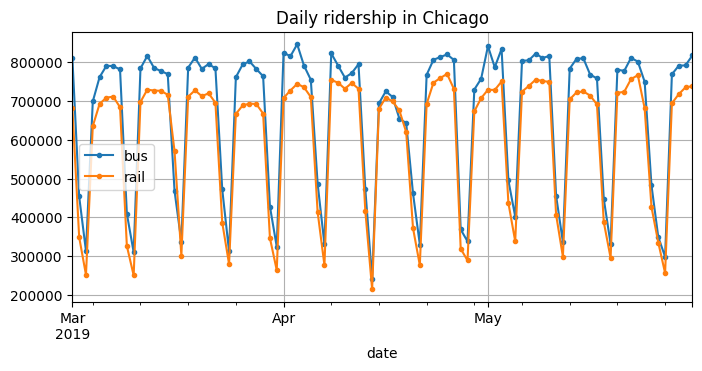

In [5]:
df['2019-03':'2019-05'].plot(grid=True, marker='.', figsize=(8, 3.5))
plt.title('Daily ridership in Chicago')
plt.show()

In [6]:
diff_7 = df[['bus','rail']].diff(7)['2019-03':'2019-05']

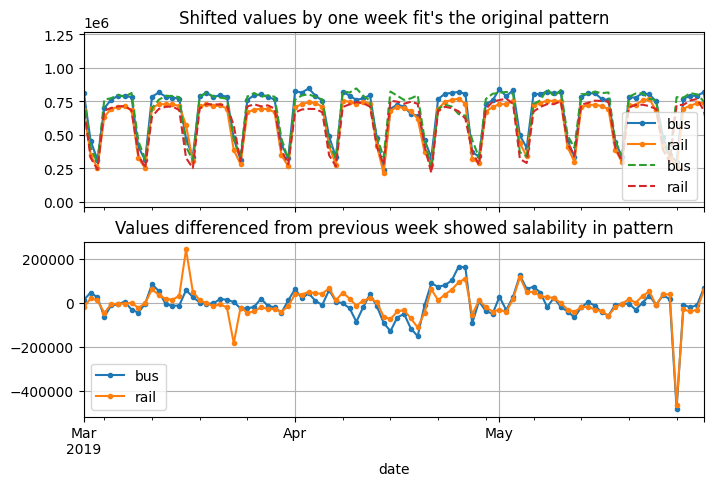

In [7]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 5))
df.plot(ax=axs[0], legend=True, marker=".")  # original time series
df.shift(7).plot(ax=axs[0], grid=True, legend=True, linestyle="--")  # lagged
diff_7.plot(ax=axs[1], grid=True, marker=".")  # 7-day difference time series

axs[0].set_title("Shifted values by one week fit's the original pattern")
axs[1].set_title("Values differenced from previous week showed salability in pattern")
plt.show()

comment:

Not too bad! Notice how closely the lagged time series track the actual time series.
When a time series is correlated with a lagged version of itself, we say that the time
series is autocorrelated. As you can see, most of the differences are fairly small, except
at the end of May. Maybe there was a holiday at that time? Let’s check the day_type
column:


In [8]:
list(df.loc["2019-05-25":"2019-05-27"]["day"])

['A', 'U', 'U']

`mean absolute error`


In [9]:
diff_7.abs().mean()

bus     43915.608696
rail    42143.271739
dtype: float64

In [10]:
targets = df[['bus','rail']]['2019-03':'2019-05']
(diff_7/targets).abs().mean()

bus     0.082938
rail    0.089948
dtype: float64

What we just computed is called the `mean absolute percentage error (MAPE)`


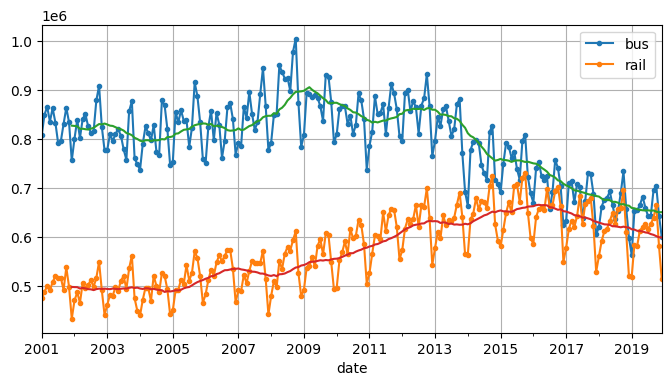

In [11]:
period = slice('2001','2019')

df_monthly = df.drop('day',axis=1).resample("M").mean()
rolling_average_12_months = df_monthly[period].rolling(window=12).mean()

fig, ax = plt.subplots(figsize=(8, 4))
df_monthly[period].plot(ax=ax, marker=".")
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)
plt.show()

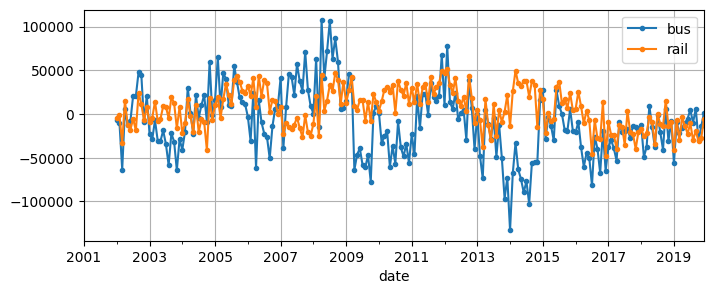

In [12]:
df_monthly[period].diff(12).plot(grid=True, marker=".", figsize=(8, 3))
plt.show()

In [13]:

origin, today = '2019-01-01', '2019-05-31'
rail_series = df.loc[origin:today]['rail'].asfreq("D")
model = ARIMA(rail_series, 
                order=(1,0,0),
                seasonal_order=(0,1,1,7),
)
model = model.fit()
y_pred = model.forecast()
y_pred, y_pred[0]

(2019-06-01    427758.626222
 Freq: D, dtype: float64,
 427758.62622240453)

In [14]:
df["rail"].loc["2019-06-01"]  # target value


379044

In [15]:
df["rail"].loc["2019-05-25"]  # naive forecast (value from one week earlier)


426932

In [16]:
origin, start_date, end_date = "2019-01-01", "2019-03-01", "2019-05-31"
time_period = pd.date_range(start_date, end_date)
rail_series = df.loc[origin:end_date]["rail"].asfreq("D")
y_preds = []
for today in time_period.shift(-1):
    model = ARIMA(rail_series[origin:today],  # train on data up to "today"
                  order=(1, 0, 0),
                  seasonal_order=(0, 1, 1, 7))
    model = model.fit()  # note that we retrain the model every day!
    y_pred = model.forecast()[0]
    y_preds.append(y_pred)

y_preds = pd.Series(y_preds, index=time_period)
mae = (y_preds - rail_series[time_period]).abs().mean()  # returns 32,040.7

In [17]:
mae

32040.720090488467

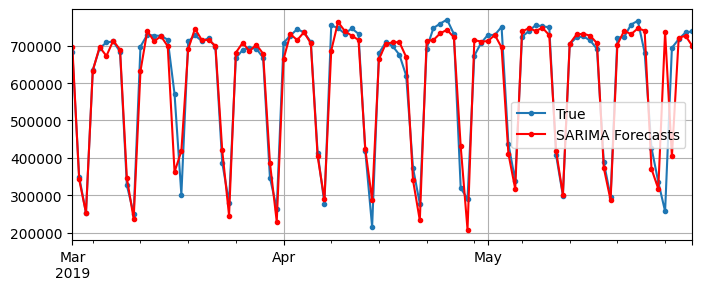

In [18]:
fig, ax = plt.subplots(figsize=(8, 3))
rail_series.loc[time_period].plot(label="True", ax=ax, marker=".", grid=True)
ax.plot(y_preds, color="r", marker=".", label="SARIMA Forecasts")
plt.legend()
plt.show()

### Preparing the Data for Machine Learning Model


In [19]:
my_series = [0,1,2,3,4,5]
my_dataset = tf.keras.utils.timeseries_dataset_from_array(
    my_series,
    targets=my_series[3:],
    sequence_length=3,
    batch_size=2,
)

In [20]:
list(my_dataset)

[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[0, 1, 2],
         [1, 2, 3]])>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([3, 4])>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[2, 3, 4]])>,
  <tf.Tensor: shape=(1,), dtype=int32, numpy=array([5])>)]

another way to take the control of creating the data using `window`


In [21]:
for window_data in tf.data.Dataset.range(6).window(4, shift=1):
    for element in window_data:
        print(f"{element}",end=' ')
    print()


0 1 2 3 
1 2 3 4 
2 3 4 5 
3 4 5 
4 5 
5 


In [22]:
for window_data in tf.data.Dataset.range(6).window(4, shift=1,drop_remainder=True):
    for element in window_data:
        print(f"{element}",end=' ')
    print(type(window_data),window_data)

0 1 2 3 <class 'tensorflow.python.data.ops.dataset_ops._VariantDataset'> <_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
1 2 3 4 <class 'tensorflow.python.data.ops.dataset_ops._VariantDataset'> <_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
2 3 4 5 <class 'tensorflow.python.data.ops.dataset_ops._VariantDataset'> <_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>


In [23]:
dataset = tf.data.Dataset.range(6).window(4, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window_dataset: window_dataset.batch(4))
for window_tensor in dataset:
    print(f"{window_tensor}")

print(dataset)

[0 1 2 3]
[1 2 3 4]
[2 3 4 5]
<FlatMapDataset element_spec=TensorSpec(shape=(None,), dtype=tf.int64, name=None)>


general method to extract consecutive windows from dataset:


In [24]:
def to_windows(dataset, length):
    dataset = dataset.window(length, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda data: data.batch(length))
    return dataset

The last step is to split each window into inputs and targets


In [25]:
dataset = to_windows(tf.data.Dataset.range(2,11), 4)
dataset = dataset.map(lambda window: (window[:-1],window[-1]))
list(dataset.batch(2))

[(<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
  array([[2, 3, 4],
         [3, 4, 5]], dtype=int64)>,
  <tf.Tensor: shape=(2,), dtype=int64, numpy=array([5, 6], dtype=int64)>),
 (<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
  array([[4, 5, 6],
         [5, 6, 7]], dtype=int64)>,
  <tf.Tensor: shape=(2,), dtype=int64, numpy=array([7, 8], dtype=int64)>),
 (<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
  array([[6, 7, 8],
         [7, 8, 9]], dtype=int64)>,
  <tf.Tensor: shape=(2,), dtype=int64, numpy=array([ 9, 10], dtype=int64)>)]

Now, before we start training, we need to split our data into a training period, a
validation period, and a test period


In [26]:
# notice we work on univariate time-series now.

rail_train = df['rail']['2016-01':'2018-12']/1e6
rail_valid = df['rail']['2019-01':'2019-05']/1e6
rail_test = df['rail']['2019-06':]/1e6

In [27]:
seq_length = 56
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42,
)

valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
)

In [28]:
sample = next(valid_ds.as_numpy_iterator())
sample[0],sample[1], sample[0].shape, sample[1].shape

(array([[0.245852, 0.573542, 0.627781, ..., 0.328179, 0.240478, 0.680844],
        [0.573542, 0.627781, 0.628514, ..., 0.240478, 0.680844, 0.699462],
        [0.627781, 0.628514, 0.348257, ..., 0.680844, 0.699462, 0.711827],
        ...,
        [0.097917, 0.243912, 0.648091, ..., 0.279989, 0.666862, 0.688849],
        [0.243912, 0.648091, 0.34565 , ..., 0.666862, 0.688849, 0.693509],
        [0.648091, 0.34565 , 0.250724, ..., 0.688849, 0.693509, 0.692421]]),
 array([0.699462, 0.711827, 0.7147  , 0.682969, 0.349392, 0.25215 ,
        0.635353, 0.692945, 0.708876, 0.711428, 0.684186, 0.326686,
        0.250702, 0.697758, 0.729476, 0.72715 , 0.726502, 0.71623 ,
        0.570703, 0.301294, 0.711535, 0.727732, 0.712714, 0.719946,
        0.695716, 0.386972, 0.279989, 0.666862, 0.688849, 0.693509,
        0.692421, 0.667916]),
 (32, 56),
 (32,))

## Forecasting Using a Linear Model


In [29]:
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[seq_length])
])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=50,
                                                        restore_best_weights=True)
loss = tf.keras.losses.Huber()
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=.9)
model.compile(loss=loss, optimizer=opt,metrics=['mae'])


In [30]:
history = model.fit(train_ds, validation_data=valid_ds,
                    epochs=500, callbacks=[early_stopping_cb])

Epoch 1/500
33/33 [==============================] - 3s 7ms/step - loss: 0.0200 - mae: 0.1563 - val_loss: 0.0054 - val_mae: 0.0801
Epoch 2/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0075 - mae: 0.0896 - val_loss: 0.0044 - val_mae: 0.0700
Epoch 3/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0073 - mae: 0.0896 - val_loss: 0.0043 - val_mae: 0.0681
Epoch 4/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0062 - mae: 0.0811 - val_loss: 0.0071 - val_mae: 0.0961
Epoch 5/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0071 - mae: 0.0887 - val_loss: 0.0034 - val_mae: 0.0588
Epoch 6/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0052 - mae: 0.0725 - val_loss: 0.0035 - val_mae: 0.0602
Epoch 7/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0050 - mae: 0.0703 - val_loss: 0.0033 - val_mae: 0.0569
Epoch 8/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0047 - m

In [31]:
valid_loss, valid_mae = model.evaluate(valid_ds)
valid_mae* 1e6

3/3 [==============================] - 0s 3ms/step - loss: 0.0023 - mae: 0.0380


37968.86280179024

### Forecasting Using a Simple RNN


In [32]:
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(1, input_shape=[None,1])
])

since recurrent layers can accept input sequences of any
length, we can set the second dimension to None, which means “any size”


In [33]:
def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=500):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=50, restore_best_weights=True)
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs,
                        callbacks=[early_stopping_cb])
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae * 1e6

In [34]:
fit_and_evaluate(model, train_ds, valid_ds, learning_rate=0.02)


Epoch 1/500
33/33 [==============================] - 2s 40ms/step - loss: 0.3891 - mae: 0.7273 - val_loss: 0.0255 - val_mae: 0.1404
Epoch 2/500
33/33 [==============================] - 1s 36ms/step - loss: 0.0521 - mae: 0.2661 - val_loss: 0.0598 - val_mae: 0.2973
Epoch 3/500
33/33 [==============================] - 1s 36ms/step - loss: 0.0364 - mae: 0.2006 - val_loss: 0.0210 - val_mae: 0.1278
Epoch 4/500
33/33 [==============================] - 1s 33ms/step - loss: 0.0186 - mae: 0.1660 - val_loss: 0.0173 - val_mae: 0.1444
Epoch 5/500
33/33 [==============================] - 1s 37ms/step - loss: 0.0175 - mae: 0.1591 - val_loss: 0.0170 - val_mae: 0.1408
Epoch 6/500
33/33 [==============================] - 1s 35ms/step - loss: 0.0171 - mae: 0.1603 - val_loss: 0.0165 - val_mae: 0.1402
Epoch 7/500
33/33 [==============================] - 1s 34ms/step - loss: 0.0166 - mae: 0.1581 - val_loss: 0.0161 - val_mae: 0.1398
Epoch 8/500
33/33 [==============================] - 1s 35ms/step - loss: 0.

102795.97342014313

fixing prev model issues ( 1- add dense on top of it to solve limits issue, 2- increase number of rnn neurons)


In [35]:
univar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None,1]),
    tf.keras.layers.Dense(1)
])

In [36]:
fit_and_evaluate(univar_model, train_ds, valid_ds, learning_rate=0.05)

Epoch 1/500
33/33 [==============================] - 2s 42ms/step - loss: 0.0377 - mae: 0.2123 - val_loss: 0.0187 - val_mae: 0.1390
Epoch 2/500
33/33 [==============================] - 1s 35ms/step - loss: 0.0117 - mae: 0.1265 - val_loss: 0.0181 - val_mae: 0.1672
Epoch 3/500
33/33 [==============================] - 1s 31ms/step - loss: 0.0105 - mae: 0.1137 - val_loss: 0.0037 - val_mae: 0.0687
Epoch 4/500
33/33 [==============================] - 1s 39ms/step - loss: 0.0049 - mae: 0.0739 - val_loss: 0.0042 - val_mae: 0.0686
Epoch 5/500
33/33 [==============================] - 1s 40ms/step - loss: 0.0045 - mae: 0.0680 - val_loss: 0.0056 - val_mae: 0.0811
Epoch 6/500
33/33 [==============================] - 1s 39ms/step - loss: 0.0043 - mae: 0.0665 - val_loss: 0.0028 - val_mae: 0.0520
Epoch 7/500
33/33 [==============================] - 1s 38ms/step - loss: 0.0037 - mae: 0.0616 - val_loss: 0.0023 - val_mae: 0.0454
Epoch 8/500
33/33 [==============================] - 1s 35ms/step - loss: 0.

29699.305072426796

### Forecasting Using a Deep RNN


In [37]:
deep_model =tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None,1]),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1),
])

In [38]:
fit_and_evaluate(deep_model, train_set=train_ds, valid_set=valid_ds, learning_rate=0.01)

Epoch 1/500
33/33 [==============================] - 6s 130ms/step - loss: 0.0894 - mae: 0.3043 - val_loss: 0.0124 - val_mae: 0.1299
Epoch 2/500
33/33 [==============================] - 4s 114ms/step - loss: 0.0135 - mae: 0.1394 - val_loss: 0.0090 - val_mae: 0.1077
Epoch 3/500
33/33 [==============================] - 4s 122ms/step - loss: 0.0087 - mae: 0.1089 - val_loss: 0.0051 - val_mae: 0.0787
Epoch 4/500
33/33 [==============================] - 4s 129ms/step - loss: 0.0063 - mae: 0.0829 - val_loss: 0.0052 - val_mae: 0.0818
Epoch 5/500
33/33 [==============================] - 4s 119ms/step - loss: 0.0058 - mae: 0.0785 - val_loss: 0.0029 - val_mae: 0.0558
Epoch 6/500
33/33 [==============================] - 4s 130ms/step - loss: 0.0048 - mae: 0.0686 - val_loss: 0.0026 - val_mae: 0.0530
Epoch 7/500
33/33 [==============================] - 4s 125ms/step - loss: 0.0051 - mae: 0.0714 - val_loss: 0.0024 - val_mae: 0.0484
Epoch 8/500
33/33 [==============================] - 4s 121ms/step - 

31181.24045431614

### Forecasting Multivariate Time Series


let’s try to forecast the rail time series using both the bus and rail data as input. In
fact, let’s also throw in the day type! Since we can always know in advance whether
tomorrow is going to be a weekday, a weekend, or a holiday, we can shift the day type
series one day into the future, so that the model is given tomorrow’s day type as input.


In [39]:
df_mulvar = df[['bus','rail']]/1e6
df_mulvar['next_day_type'] = df['day'].shift(-1)
df_mulvar = pd.get_dummies(df_mulvar,dtype=float)

In [40]:
df_mulvar.sample(2)

,bus,rail,next_day_type_A,next_day_type_U,next_day_type_W
date,,,,,
2005-03-03,1.030040,0.600570,0.0,0.0,1.0
2013-10-13,0.433578,0.528335,0.0,0.0,1.0


In [41]:
mulvar_train = df_mulvar["2016-01":"2018-12"]
mulvar_valid = df_mulvar["2019-01":"2019-05"]
mulvar_test = df_mulvar["2019-06":]

In [42]:
mulvar_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1096 entries, 2016-01-01 to 2018-12-31
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bus              1096 non-null   float64
 1   rail             1096 non-null   float64
 2   next_day_type_A  1096 non-null   float64
 3   next_day_type_U  1096 non-null   float64
 4   next_day_type_W  1096 non-null   float64
dtypes: float64(5)
memory usage: 51.4 KB


In [ ]:
train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),  # use all 5 columns as input
    targets=mulvar_train["rail"][seq_length:],  # forecast only the rail series
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=mulvar_valid["rail"][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [44]:
mulvar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),# 5 for the 5 features included.
    tf.keras.layers.Dense(1)
])

fit_and_evaluate(mulvar_model, train_mulvar_ds, valid_mulvar_ds,
                 learning_rate=0.05)

Epoch 1/500
33/33 [==============================] - 2s 44ms/step - loss: 0.0706 - mae: 0.2662 - val_loss: 0.0033 - val_mae: 0.0682
Epoch 2/500
33/33 [==============================] - 1s 35ms/step - loss: 0.0037 - mae: 0.0647 - val_loss: 0.0039 - val_mae: 0.0790
Epoch 3/500
33/33 [==============================] - 1s 34ms/step - loss: 0.0026 - mae: 0.0535 - val_loss: 0.0018 - val_mae: 0.0494
Epoch 4/500
33/33 [==============================] - 1s 34ms/step - loss: 0.0021 - mae: 0.0469 - val_loss: 0.0031 - val_mae: 0.0719
Epoch 5/500
33/33 [==============================] - 1s 32ms/step - loss: 0.0018 - mae: 0.0416 - val_loss: 9.1239e-04 - val_mae: 0.0308
Epoch 6/500
33/33 [==============================] - 1s 36ms/step - loss: 0.0016 - mae: 0.0405 - val_loss: 0.0019 - val_mae: 0.0522
Epoch 7/500
33/33 [==============================] - 1s 32ms/step - loss: 0.0019 - mae: 0.0452 - val_loss: 0.0012 - val_mae: 0.0381
Epoch 8/500
33/33 [==============================] - 1s 36ms/step - loss

23252.36424803734

In [45]:
# build and train a multitask RNN that forecasts both bus and rail

tf.random.set_seed(42)

seq_length = 56
train_multask_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=mulvar_train[["bus", "rail"]][seq_length:],  # 2 targets per day
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_multask_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=mulvar_valid[["bus", "rail"]][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

tf.random.set_seed(42)
multask_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(2)
])

fit_and_evaluate(multask_model, train_multask_ds, valid_multask_ds,
                 learning_rate=0.02)

Epoch 1/500
33/33 [==============================] - 2s 48ms/step - loss: 0.0139 - mae: 0.1134 - val_loss: 0.0029 - val_mae: 0.0566
Epoch 2/500
33/33 [==============================] - 2s 45ms/step - loss: 0.0037 - mae: 0.0584 - val_loss: 0.0017 - val_mae: 0.0423
Epoch 3/500
33/33 [==============================] - 1s 44ms/step - loss: 0.0028 - mae: 0.0500 - val_loss: 0.0011 - val_mae: 0.0331
Epoch 4/500
33/33 [==============================] - 1s 42ms/step - loss: 0.0024 - mae: 0.0473 - val_loss: 0.0017 - val_mae: 0.0447
Epoch 5/500
33/33 [==============================] - 2s 46ms/step - loss: 0.0022 - mae: 0.0456 - val_loss: 0.0011 - val_mae: 0.0351
Epoch 6/500
33/33 [==============================] - 1s 45ms/step - loss: 0.0021 - mae: 0.0445 - val_loss: 0.0011 - val_mae: 0.0358
Epoch 7/500
33/33 [==============================] - 2s 45ms/step - loss: 0.0020 - mae: 0.0434 - val_loss: 9.3128e-04 - val_mae: 0.0324
Epoch 8/500
33/33 [==============================] - 2s 47ms/step - loss

26697.734370827675

In [46]:
# evaluate the model:

y_pred_valid = multask_model.predict(valid_multask_ds)
for idx, name in enumerate(['bus','rail']):
    mae = 1e6* tf.keras.metrics.mean_absolute_error(
        mulvar_valid[name][seq_length:],y_pred_valid[:, idx])
    print(name , int(mae))



3/3 [==============================] - 0s 9ms/step
bus 26929
rail 26465


### forecasting several time steps ahead.


#### Recursive Method


In [52]:
univar_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 32)                1088      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________


In [59]:
import numpy as np


X = rail_valid.to_numpy()[np.newaxis, :seq_length, np.newaxis]
print("X shape: ",X.shape)# this is because rnn expects 3d input (number of batches, time steps, features)
for step_ahead in range(14): # predict next 14 days
    day_predicted = univar_model.predict(X).reshape(1,1,1)
    X = np.concatenate([X, day_predicted],axis=1)
    print("X shape: ",X.shape)


X shape:  (1, 56, 1)
1/1 [==============================] - 0s 25ms/step
X shape:  (1, 57, 1)
1/1 [==============================] - 0s 23ms/step
X shape:  (1, 58, 1)
1/1 [==============================] - 0s 28ms/step
X shape:  (1, 59, 1)
1/1 [==============================] - 0s 22ms/step
X shape:  (1, 60, 1)
1/1 [==============================] - 0s 22ms/step
X shape:  (1, 61, 1)
1/1 [==============================] - 0s 23ms/step
X shape:  (1, 62, 1)
1/1 [==============================] - 0s 22ms/step
X shape:  (1, 63, 1)
1/1 [==============================] - 0s 22ms/step
X shape:  (1, 64, 1)
1/1 [==============================] - 0s 23ms/step
X shape:  (1, 65, 1)
1/1 [==============================] - 0s 22ms/step
X shape:  (1, 66, 1)
1/1 [==============================] - 0s 24ms/step
X shape:  (1, 67, 1)
1/1 [==============================] - 0s 26ms/step
X shape:  (1, 68, 1)
1/1 [==============================] - 0s 28ms/step
X shape:  (1, 69, 1)
1/1 [=========================

#### Second Method: Predicting the next 14 days once.


In [61]:
mulvar_train.sample(1)

,bus,rail,next_day_type_A,next_day_type_U,next_day_type_W
date,,,,,
2017-11-28,0.84791,0.753208,0.0,0.0,1.0


In [72]:
def split_inputs_and_targets(mulvar_series, ahead=14, target_col=1):
    # this function split the batch arrived into data, target ( rail 14 values )
    return mulvar_series[:, :-ahead], mulvar_series[:, -ahead:, target_col]

ahead_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32,
    shuffle=True,
    seed=42
).map(split_inputs_and_targets)


ahead_valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32
).map(split_inputs_and_targets)

In [73]:
tf.random.set_seed(42)

ahead_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None,5]),
    tf.keras.layers.Dense(14),
])

#### Prediction of the next 14 days


In [75]:
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length, :]
Y_pred = ahead_model.predict(X)
Y_pred

1/1 [==============================] - 0s 93ms/step


array([[0.73698395, 0.7095018 , 0.679466  , 0.6766063 , 0.39639422,
        0.26661503, 0.60866755, 0.6683259 , 0.72598326, 0.7091458 ,
        0.6860212 , 0.37947425, 0.28918824, 0.63163275]], dtype=float32)

### Forecasting Using a Sequence-to-Sequence Model


In [80]:
my_series = tf.data.Dataset.range(7)
dataset = to_windows(to_windows(my_series,3),4)
list(dataset)

[<tf.Tensor: shape=(4, 3), dtype=int64, numpy=
 array([[0, 1, 2],
        [1, 2, 3],
        [2, 3, 4],
        [3, 4, 5]], dtype=int64)>,
 <tf.Tensor: shape=(4, 3), dtype=int64, numpy=
 array([[1, 2, 3],
        [2, 3, 4],
        [3, 4, 5],
        [4, 5, 6]], dtype=int64)>]

In [81]:
dataset = dataset.map(lambda s : (s[:,0], s[:,1:]))
list(dataset)

[(<tf.Tensor: shape=(4,), dtype=int64, numpy=array([0, 1, 2, 3], dtype=int64)>,
  <tf.Tensor: shape=(4, 2), dtype=int64, numpy=
  array([[1, 2],
         [2, 3],
         [3, 4],
         [4, 5]], dtype=int64)>),
 (<tf.Tensor: shape=(4,), dtype=int64, numpy=array([1, 2, 3, 4], dtype=int64)>,
  <tf.Tensor: shape=(4, 2), dtype=int64, numpy=
  array([[2, 3],
         [3, 4],
         [4, 5],
         [5, 6]], dtype=int64)>)]

#### Transforming the data into seq2seq dataset


In [84]:
def to_seq2seq_dataset(series, seq_length=56, ahead=14, target_col=1,
                        batch_size=32, shuffle=False, seed=None):
    ds = to_windows(tf.data.Dataset.from_tensor_slices(series),ahead+1)
    ds = to_windows(ds, seq_length).map(lambda x:(x[:,0],x[:,1:,1]))
    if shuffle:
        ds = ds.shuffle(8 * batch_size, seed=seed)
    return ds.batch(batch_size)

seq2seq_train = to_seq2seq_dataset(mulvar_train, shuffle=True, seed=42)
seq2seq_valid = to_seq2seq_dataset(mulvar_valid)

In [85]:
seq2seq_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

In [87]:
fit_and_evaluate(seq2seq_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1)

Epoch 1/500
33/33 [==============================] - 2s 44ms/step - loss: 0.0040 - mae: 0.0570 - val_loss: 0.0040 - val_mae: 0.0540
Epoch 2/500
33/33 [==============================] - 1s 40ms/step - loss: 0.0041 - mae: 0.0577 - val_loss: 0.0039 - val_mae: 0.0531
Epoch 3/500
33/33 [==============================] - 1s 39ms/step - loss: 0.0040 - mae: 0.0571 - val_loss: 0.0039 - val_mae: 0.0525
Epoch 4/500
33/33 [==============================] - 1s 42ms/step - loss: 0.0040 - mae: 0.0562 - val_loss: 0.0040 - val_mae: 0.0534
Epoch 5/500
33/33 [==============================] - 1s 43ms/step - loss: 0.0039 - mae: 0.0553 - val_loss: 0.0039 - val_mae: 0.0515
Epoch 6/500
33/33 [==============================] - 1s 43ms/step - loss: 0.0039 - mae: 0.0555 - val_loss: 0.0039 - val_mae: 0.0522
Epoch 7/500
33/33 [==============================] - 1s 40ms/step - loss: 0.0040 - mae: 0.0561 - val_loss: 0.0037 - val_mae: 0.0501
Epoch 8/500
33/33 [==============================] - 1s 44ms/step - loss: 0.

46665.35183787346

In [92]:
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length]
y_pred_14 = seq2seq_model.predict(X)[0,-1]
y_pred_14.shape

1/1 [==============================] - 0s 23ms/step


(14,)

### Handling Long Sequences
